# Membaca  Perilaku Pengguna pada Start-Up Produk Makanan berdasarkan Analisis Reguler dan Analisis A/A/B

Kamu bekerja di sebuah startup yang menjual produk makanan. Kamu perlu mencari tahu perilaku pengguna aplikasi dari perusahaan tersebut.
   1. Pertama-tama, kamu perlu mempelajari funnel penjualannya terlebih dahulu.
   2. Kemudian, lihat hasil dari A/A/B testing (Baca terus untuk mengetahui informasi lebih lanjut tentang A/A/B testing).
Para pengguna dibagi menjadi tiga kelompok: dua kelompok kontrol diperlihatkan dengan versi font lama dan satu kelompok uji diperlihatkan dengan versi font terbaru. Tugasmu adalah mencari tahu font mana yang akan memberi hasil terbaik.

Jika ada perbedaan yang signifikan di antara kedua kelompok A, hal ini bisa membantu kita untuk mengidentifikasi faktor-faktor yang mungkin mendistorsi hasil yang kita peroleh. Kamu akan menggunakan dataset yang sama untuk melakukan analisis reguler dan untuk melakukan analisis A/A/B.

Tujuan : Memperoleh informasi pengguna berdasarkan peristiwa terhadap kelompok-kelompok tertentu (246, 247, dan 248) pada analisis reguler dan analisis A/A/B.

## Deskripsi Data

Dataframe `logs_exp_us` memuat:
   - `EventName` — Nama peristiwa
   - `DeviceIDHash` — ID unik pengguna
   - `EventTimestamp` —  Waktu Peristiwa
   - `ExpId` — Nomor eksperimen: 246 dan 247 untuk kelompok kontrol, 248 untuk kelompok uji

## Inisialisasi Libraries

Import library

In [39]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from plotly import graph_objects as go

Memuat data

In [40]:
try:
    logs_data = pd.read_csv('logs_exp_us.csv', sep='\t')
except:
    logs_data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

## Mengenal Data

Total data ada 244126 logs untuk analisis kali ini

In [41]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [42]:
logs_data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Melihat data duplikat dan terdapat beberapa nilai yang terduplikasi berjumlahkan 413 dari keseluruhan data

In [43]:
logs_data.duplicated().sum()

413

Pada data missing tidak ditemukannya nilai tersebut

In [44]:
report_null = logs_data.isnull().sum().to_frame()
report_null = report_null.rename(columns={0:'missing_values'})
report_null['% of total'] = (report_null['missing_values'] / logs_data.shape[0]).round(2)
report_null.sort_values(by='missing_values', ascending=False)

,missing_values,% of total
EventName,0,0.0
DeviceIDHash,0,0.0
EventTimestamp,0,0.0
ExpId,0,0.0


### Memperbaiki Data

Mengeliminasi nilai duplikat

In [45]:
logs_data = logs_data.drop_duplicates()

Mengubah nama kolom

In [46]:
logs_data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

### Memperkaya Data

Menambahkan kolom baru berdasarkan kolom 'event_timestamp' untuk merubah tipe data timestamp ke datetime

In [47]:
logs_data['event_datetime'] = pd.to_datetime(logs_data['event_timestamp'], unit='s')

Menambahkan beberapa kolom lagi untuk waktu kolom hari dan waktu

In [48]:
logs_data['event_date'] = logs_data['event_datetime'].dt.date

In [49]:
logs_data['event_time'] = logs_data['event_datetime'].dt.time

In [50]:
logs_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date,event_time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,11:48:42


## Mempelajari Data

Mempelajari data yang tidak dipengaruhi oleh anomali atau outlier dalam populasi statistik

Mencari tahu jumlah logs pada data berdasarkan peristiwa

In [51]:
logs_data[['event_name']].reset_index().groupby('event_name').count()

,index
event_name,
CartScreenAppear,42668
MainScreenAppear,119101
OffersScreenAppear,46808
PaymentScreenSuccessful,34118
Tutorial,1018


Mencari jumlah pengguna unique

In [52]:
logs_data['device_id_hash'].nunique()

7551

Jumlah rata-rata per pengguna

In [53]:
logs_data[['device_id_hash']].reset_index().groupby('device_id_hash').count()['index'].mean()

32.27559263673685

In [54]:
str(logs_data['event_date'].min())

'2019-07-25'

In [55]:
str(logs_data['event_date'].max())

'2019-08-07'

Nilai awal waktu peristiwa yang dimiliki data: 2019-07-25
Nilai akhir waktu peristiwa yang dimiliki data: 2019-08-07

Data memuat waktu selama <> 13 hari

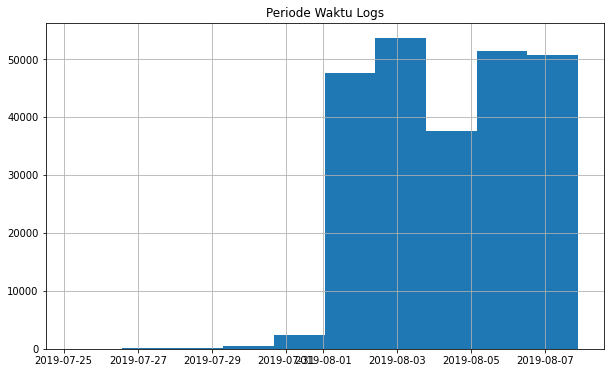

In [56]:
plt.figure(figsize=(10, 6))
plt.title('Periode Waktu Logs')
logs_data['event_datetime'].hist(bins=10)
plt.show()

Periode waktu logs:
1. Data lebih terpusat pada tanggal '2019-08-01' sampai '2019-08-07'.
2. Sepertinya waktu yang dicakup oleh data termasuk dengan data lama, sehingga tingkat relevansinya rendah karena peristiwa yang tersimpan terpaut jauh dengan data yang baru.
3. Disimpulkan untuk data abnormal/nilai outlier ada pada tanggal 2019-07-25 --> 2019-07-31.

In [57]:
logs_data.groupby('event_date')['device_id_hash'].count().reset_index().head(10)

,event_date,device_id_hash
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


mengeliminasi peristiwa terdahulu yang muncul dalam log beberapa pengguna karena alasan teknis

In [58]:
data_filtered = logs_data.query('event_datetime > "2019-07-31 23:59:59"')
data_filtered.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date,event_time
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,00:08:59


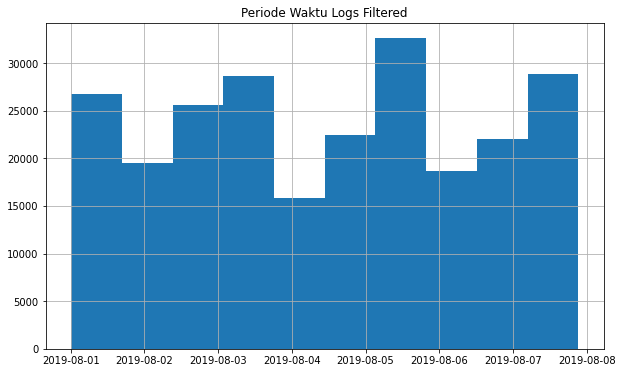

In [59]:
plt.figure(figsize=(10, 6))
plt.title('Periode Waktu Logs Filtered')
data_filtered['event_datetime'].hist(bins=10)
plt.show()

Periode waktu logs terfilter:
1. Data memiliki grafik yang rata-rata berada pada nilai 20000 - 25000.
2. Data outlier sudah tidak deteksi dan siap untuk kita analisis lebih jauh.

In [60]:
logs = (len(logs_data) - len(data_filtered)) / len(logs_data) * 100
logs

1.159560630741897

1% dari data telah kita filter

In [61]:
data_filtered['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Terlihat jumlah data untuk setiap group tidak terpaut jauh. Hanya saja pada group 248 sedikit lebih tinggi dari 246 dan 247.

## Analisis Data

### Funnel Peristiwa

Saatnya kita menganalisis data mulai dari peristiwa yang terjadi

Terlihat pada kolom event_name yang merupakan peristiwa dari pelanggan, MainScreenAppear yang memiliki jumlah frakuensi terbanyak dengan nilai 117328

In [62]:
time = data_filtered.pivot_table(index='event_name', values='event_time', aggfunc='count').reset_index().sort_values(by='event_time', ascending=False)
time

,event_name,event_time
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


jumlah pengguna yang melakukan setiap tindakan setidaknya satu kali

In [63]:
device_id = data_filtered.pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique').reset_index().sort_values(by='device_id_hash', ascending=False)
device_id.columns = ['event_name', 'id']
device_id

,event_name,id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Peristiwa Tutorial memiliki nilai yang terpaut jauh dengan yang lain, serta posisinya yang paling bawah mengindikasikan bahwa peristiwa tersebut jarang di lalui oleh pelanggan. Sepertinya banyak orang yang skip untuk langkah ini.

Kita akan mengelompokkan data berdasarkan setiap pelanggan lalu kita hitung funnel peristiwa untuk mengetahui peristiwa secara berurutan dari awal hingga akhir.

In [64]:
users = data_filtered.pivot_table(
    index='device_id_hash', 
    columns='event_name', 
    values='event_time',
    aggfunc='min')
users = users.drop(columns='Tutorial')

Kita tentukan langkah-langkahnya mulai dari nilai terbesar ke yang terkecil

In [65]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_MainScreenAppear = users[step_1].shape[0]
n_OffersScreenAppear = users[step_2].shape[0]
n_CartScreenAppear = users[step_3].shape[0]
n_PaymentScreenSuccessful = users[step_4].shape[0]

print(f'Main Screen Appear: {n_MainScreenAppear}')
print(f'Offers Screen Appear: {n_OffersScreenAppear}')
print(f'Cart Screen Appear: {n_CartScreenAppear}')
print(f'Payment Screen Successful: {n_PaymentScreenSuccessful}')

Main Screen Appear: 7419
Offers Screen Appear: 4103
Cart Screen Appear: 1882
Payment Screen Successful: 440


In [66]:
print(f'Funnel, Main Screen Appear: {n_MainScreenAppear / n_MainScreenAppear:.1%}')
print(f'Funnel, Offers Screen Appear: {n_OffersScreenAppear / n_MainScreenAppear:.1%}')
print(f'Funnel, Cart Screen Appear: {n_CartScreenAppear / n_OffersScreenAppear:.1%}')
print(f'Funnel, Payment Screen Successful: {n_PaymentScreenSuccessful / n_CartScreenAppear:.1%}')

Funnel, Main Screen Appear: 100.0%
Funnel, Offers Screen Appear: 55.3%
Funnel, Cart Screen Appear: 45.9%
Funnel, Payment Screen Successful: 23.4%


In [67]:
fig = go.Figure(go.Funnel(
    y = ['Main Screen Appear', 'Offers Screen Appear', 'Cart Screen Appear', 'Payment Screen Successful'],
    x = [n_MainScreenAppear, n_OffersScreenAppear, n_CartScreenAppear, n_PaymentScreenSuccessful]
    ))
fig.show()

Funnel Peristiwa Table:
- Funnel grafik menggambarkan kerucut yang tajam.
- Pada peristiwa cart screen -->> payment terjadi pengurangan pengguna yang cukup banyak dengan presentase 23.4%
- Proses peristiwa ini cukup normal, hanya saja pada bagian payment sedikit terpaut jauh perbandingan dengan peristiwa yang lain. Sepertinya kita perlu mencari tahu lebih lanjut.

### Mempelajari Hasil Analisis A/A/B

Kita akan mempelajari hasil dari uji A/B mulai dari malihat jumlah pengguna yang ada di setiap kelompok. 

In [68]:
group_id = data_filtered.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')
group_id['ratio_%'] = group_id['device_id_hash'] / group_id['device_id_hash'].sum() * 100
group_id

,device_id_hash,ratio_%
exp_id,,
246,2484,32.970534
247,2513,33.355455
248,2537,33.674011


In [69]:
group_event = data_filtered.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')
group_event.sort_values(by=246, ascending=False)

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Selisih jumlah pengguna dari masing-masing kelompok tidak lebih dari 1%, ini juga mengindikasikan sample dapat kita gunakan untuk uji hipotesis selanjutnya.

Karena nilainya tidak terpaut terlalu jauh antara satu sample dengan yang lain, maka bisa kita asumsikan adanya kesetaraan proporsi.

Uji Statistik : Z-test dependent

Hipotesis :
   - H0 = Apabila jumlah pengguna di suatu peristiwa pada suatu kelompok yaitu Sama
   - H1 = Apabila jumlah pengguna di suatu peristiwa pada suatu kelompok yaitu Tidak Sama
   
Alpha : 5% / 0.05

In [70]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))
    distr =  stats.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Menolak hipotesis nol: ada perbedaan yang signifikan di antara proporsinya")
    else:
        print("Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda")

In [71]:
def check_event_hypothesis(group_event, 
                        group_id, 
                        event,
                        exp1, 
                        exp2):
    frac1 = group_event.loc[event, exp1] / group_id.loc[exp1, 'device_id_hash']
    frac2 = group_event.loc[event, exp2] / group_id.loc[exp2, 'device_id_hash']
    print(f'event: {event}, group: {exp1}')
    print(f'event: {event}, group: {exp2}')
    check_hypothesis(group_event.loc[event, exp1], 
                 group_event.loc[event, exp2], 
                 group_id.loc[exp1, 'device_id_hash'], 
                 group_id.loc[exp2, 'device_id_hash'])

In [72]:
for event in group_event.index:
    check_event_hypothesis(group_event, group_id, event, 246, 247)
    print('-----------------------------------------------------------')

event: CartScreenAppear, group: 246
event: CartScreenAppear, group: 247
p-value:  0.22883372237997213
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: MainScreenAppear, group: 246
event: MainScreenAppear, group: 247
p-value:  0.7570597232046099
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: OffersScreenAppear, group: 246
event: OffersScreenAppear, group: 247
p-value:  0.2480954578522181
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: PaymentScreenSuccessful, group: 246
event: PaymentScreenSuccessful, group: 247
p-value:  0.11456679313141849
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya 

Hipotesis Kelompok 246 dan 247:
- Dari kelima peristiwa pengguna, kesimpulannya adalah H1 / Gagal untuk menolak hipotesis nol.
- P-value yang paling mendekati alpha yaitu PaymentScreenSuccessful di angka 0.11.
- Penggunaan font berukuran 246 dan 247 tidak terlalu memberikan dampak signifikan dikarenakan tidak ditemukan perbedaan proporsi dengan titik kritis di 11% PaymentScreenSuccessful.

In [73]:
for event in group_event.index:
    check_event_hypothesis(group_event, group_id, event, 247, 248)
    print('-----------------------------------------------------------')

event: CartScreenAppear, group: 247
event: CartScreenAppear, group: 248
p-value:  0.5786197879539783
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: MainScreenAppear, group: 247
event: MainScreenAppear, group: 248
p-value:  0.4587053616621515
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: OffersScreenAppear, group: 247
event: OffersScreenAppear, group: 248
p-value:  0.9197817830592261
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: PaymentScreenSuccessful, group: 247
event: PaymentScreenSuccessful, group: 248
p-value:  0.7373415053803964
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya be

Hipotesis Kelompok 247 dan 248:
- Dari kelima peristiwa pengguna, kesimpulannya adalah H1 / Gagal untuk menolak hipotesis nol.
- P-value yang paling mendekati alpha yaitu MainScreenAppear di angka 0.45.
- Penggunaan font berukuran 247 dan 248 tidak terlalu memberikan dampak signifikan dikarenakan tidak ditemukan perbedaan proporsi dengan titik kritis di 45% PaymentScreenSuccessful.

In [74]:
for event in group_event.index:
    check_event_hypothesis(group_event, group_id, event, 246, 248)
    print('-----------------------------------------------------------')

event: CartScreenAppear, group: 246
event: CartScreenAppear, group: 248
p-value:  0.07842923237520116
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: MainScreenAppear, group: 246
event: MainScreenAppear, group: 248
p-value:  0.2949721933554552
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: OffersScreenAppear, group: 246
event: OffersScreenAppear, group: 248
p-value:  0.20836205402738917
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-----------------------------------------------------------
event: PaymentScreenSuccessful, group: 246
event: PaymentScreenSuccessful, group: 248
p-value:  0.2122553275697796
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya 

Hipotesis Kelompok 246 dan 248:
- Dari kelima peristiwa pengguna, kesimpulannya adalah H1 / Gagal untuk menolak hipotesis nol.
- P-value yang paling mendekati alpha yaitu CartScreenAppear di angka 0.078.
- Penggunaan font berukuran 246 dan 248 memiliki titik kritis pada 7% CartScreenAppear. Nilai ini terbilang sangat mendekati nilai alpha, akan tetapi tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda. Jika nilai alpha kita ubah menjadi 0.07 maka bisa dipastikan hipotesis 0 akan ditolak.

## Kesimpulan Umum

In [75]:
logs_data.shape

(243713, 7)

Diawali dengan inisialisasi library pandas, numpy, math, scipy, plotly, dan matplotlib. Total data yang dimiliki berjumlah 244126 logs. Dengan adanya nilai duplikasi 413 data, maka total data menjadi 243713 dengan 7 total kolom. Ada penambahan kolom baru seperti kolom tanggal dan waktu dari hasil konversi nilai pada kolom timestamp.

Selanjutnya mempelajari data untuk mencari anomali atau outlier dalam populasi statistik. Terindikasi pada grafik histogram "Periode waktu logs":
   1. Data lebih terpusat pada tanggal '2019-08-01' sampai '2019-08-07'.
   2. Sepertinya waktu yang dicakup oleh data termasuk dengan data lama, sehingga tingkat relevansinya rendah karena peristiwa yang tersimpan terpaut jauh dengan data yang baru.
   3. Disimpulkan untuk data abnormal/nilai outlier ada pada tanggal 2019-07-25 --> 2019-07-31.
   
Kita lakukan eliminasi peristiwa yang terdahulu dan memulainya pada tanggal 2019-08-01 hingga data yang terbaru dengan kurun waktu menjadi 7 hari dari total 13 hari.

Tahap analisis data berdasarkan peristiwa dari pelanggan, MainScreenAppear yang memiliki jumlah frakuensi terbanyak dengan nilai 117328 dan Tutorial dengan jumlah 1005. Peristiwa Tutorial memiliki nilai yang terpaut jauh dengan yang lain, serta posisinya yang paling bawah (dari funnel) mengindikasikan bahwa peristiwa tersebut jarang di lalui oleh pelanggan. Sepertinya banyak orang yang skip untuk langkah ini.

Terindikasi pada Funnel Peristiwa:
   1. Pada peristiwa cart screen -->> payment terjadi pengurangan pengguna yang cukup banyak dengan presentase 23.4%
   2. Proses peristiwa ini cukup normal, hanya saja pada bagian payment sedikit terpaut jauh perbandingan dengan peristiwa yang lain. Sepertinya kita perlu mencari tahu lebih lanjut.
   
Selisih jumlah pengguna dari masing-masing kelompok tidak lebih dari 1%, ini juga mengindikasikan sample dapat kita gunakan untuk uji hipotesis selanjutnya. Karena nilainya tidak terpaut terlalu jauh antara satu sample dengan yang lain, maka bisa kita asumsikan adanya kesetaraan proporsi.

   - Uji Statistik : Z-test dependent
   - Hipotesis :
        - H0 = Apabila jumlah pengguna di suatu peristiwa pada suatu kelompok yaitu Sama
        - H1 = Apabila jumlah pengguna di suatu peristiwa pada suatu kelompok yaitu Tidak Sama
   - Alpha : 5% / 0.05
   
Hasil Hipotesis:
1. Kelompok 246 dan 247
   - Penggunaan font berukuran 246 dan 247 tidak terlalu memberikan dampak signifikan dikarenakan tidak ditemukan perbedaan proporsi dengan titik kritis di 11% PaymentScreenSuccessful.
2. Kelompok 247 dan 248
   - Penggunaan font berukuran 247 dan 248 tidak terlalu memberikan dampak signifikan dikarenakan tidak ditemukan perbedaan proporsi dengan titik kritis di 45% PaymentScreenSuccessful.
3. Kelompok 246 dan 248
   - Penggunaan font berukuran 246 dan 248 memiliki titik kritis pada 7% CartScreenAppear. Nilai ini terbilang sangat mendekati nilai alpha, akan tetapi tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda. Jika nilai alpha kita ubah menjadi 0.07 maka bisa dipastikan hipotesis 0 akan ditolak.